In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import plotly.express as px
import matplotlib.dates as mdates
import re

%matplotlib inline 

In [2]:
assessments = pd.read_csv('assessments.csv')
courses = pd.read_csv('courses.csv')
students = pd.read_csv('studentAssessment.csv')
registrations = pd.read_csv('studentRegistration.csv')

Посмотрим на экзамены, увидим что они есть по всем предметам, по предмету CCC их два(к этому еще вернусь). У некоторых экзаменов срок выполениния стоит NaN, предположу что это для экзаменов с фиксированный датой проведения и без дедлайна, что будет проверено при выполеннии 1й задачи.

In [3]:
assessments.query('assessment_type == "Exam"')

,code_module,code_presentation,id_assessment,assessment_type,date,weight
5,AAA,2013J,1757,Exam,NaN,100.0
11,AAA,2014J,1763,Exam,NaN,100.0
23,BBB,2013B,14990,Exam,NaN,100.0
35,BBB,2013J,15002,Exam,NaN,100.0
47,BBB,2014B,15014,Exam,NaN,100.0
53,BBB,2014J,15025,Exam,NaN,100.0
62,CCC,2014B,24290,Exam,NaN,100.0
63,CCC,2014B,40087,Exam,NaN,100.0
72,CCC,2014J,24299,Exam,NaN,100.0
73,CCC,2014J,40088,Exam,NaN,100.0


А так же определим есть ли работы с очень большим весом ведь их тоже можно считать экзаменами. Из опыта в университете зачет считалося 50% от максимума, поэтому работу с весом 50% и более можно было бы сичтать экзаменом. Однако ниже увидим, что таких работ нет и экзамен это только когда assessment_type == "Exam"

In [4]:
assessments\
    .groupby('weight')\
    .agg({'assessment_type':'unique'})\
    .sort_values('weight', ascending=False)

,assessment_type
weight,
100.0,[Exam]
35.0,[TMA]
30.0,[TMA]
28.0,[TMA]
25.0,[TMA]
22.0,[TMA]
20.0,[TMA]
18.0,[TMA]
17.5,[TMA]


Студенты сдают только экзамены по предметам CCC	и DDD. В наличии листы с студентами на каждом экзамене, можно проверить есть ли курсы длиной более 1 семестра и может ли быть крус где преподают оба предмета CCC и DDD.
По остальным предметам экзаменов не проводится, для заданий 1-3, 5 и 6 они не актуальны. 

In [5]:
exams_check = students.merge(assessments, how='left', on=['id_assessment'])\
    .query('assessment_type == "Exam"')\
    .groupby(['code_module','code_presentation','id_assessment'], as_index=False)\
    .agg({'id_student':list})\
#    .pivot(index='code_presentation', columns='code_module', values='id_student')\
#    .reset_index()
exams_check['student_count'] = [len(exams_check.id_student[i]) for i in range(0,6)]
exams_check

,code_module,code_presentation,id_assessment,id_student,student_count
0,CCC,2014B,24290,"[558914, 559706, 559770, 560114, 560311, 56049...",747
1,CCC,2014J,24299,"[558839, 559863, 560064, 560065, 560554, 56078...",1168
2,DDD,2013B,25340,"[45664, 52014, 53488, 60135, 67602, 67785, 694...",602
3,DDD,2013J,25354,"[559096, 559123, 559140, 559540, 559680, 55990...",968
4,DDD,2014B,25361,"[24213, 46753, 50476, 51030, 64450, 67781, 845...",524
5,DDD,2014J,25368,"[653452, 653550, 653569, 653711, 653729, 65376...",950


In [6]:
same_students = [[0] * 6 for i in range(6)]
for i in range(5):
    for j in range(i+1,6):
        same_students[i][j] = len(set(exams_check.iloc[i]['id_student']) & set(exams_check.iloc[j]['id_student']))
same_students

[[0, 0, 43, 47, 10, 3],
 [0, 0, 8, 97, 64, 50],
 [0, 0, 0, 0, 2, 0],
 [0, 0, 0, 0, 0, 2],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0]]

При количествах студентов больше 500 на каждом предмете в семестре пресечений крайне мало или нет вовсе. Нет такого что человек сдал экзамен в семестре и прордолжил изучать этот же предмет в следующем, и студентов изучающих CCC и DDD тоже очень мало, значит эти предметы не находятся в одном курсе.

In [7]:
courses.merge(assessments, how='inner', on=['code_module','code_presentation'])\
    .query('assessment_type == "Exam" and (code_module == "CCC" or code_module == "DDD")')

,code_module,code_presentation,module_presentation_length,id_assessment,assessment_type,date,weight
62,CCC,2014J,269,24299,Exam,NaN,100.0
63,CCC,2014J,269,40088,Exam,NaN,100.0
72,CCC,2014B,241,24290,Exam,NaN,100.0
73,CCC,2014B,241,40087,Exam,NaN,100.0
80,DDD,2013J,261,25354,Exam,261.0,100.0
87,DDD,2014J,262,25368,Exam,NaN,100.0
101,DDD,2013B,240,25340,Exam,240.0,100.0
108,DDD,2014B,241,25361,Exam,241.0,100.0


У имеющихся экзаменов даты либо NaN, либо совпадают с концом семестра, можно им пользоваться как дедлайном экзамена.

# Задание 1

1. Сколько студентов успешно сдали только один курс? (Успешная сдача — это зачёт по курсу на экзамене) (7 баллов).

In [8]:
exams = students.merge(assessments, how='left', on=['id_assessment'])\
    .merge(courses, how='inner', on=['code_module','code_presentation'])\
    .query('assessment_type == "Exam"')\
    .drop(columns=['assessment_type', 'date','weight'])\
    .rename(columns={'module_presentation_length':'date'})
exams['passed'] = np.where((exams['score']>=40), 1, 0)
exams = exams.assign(pass_date = exams.date_submitted/exams.date*100)
exams

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,date,passed,pass_date
52923,24290,558914,230,0,32.0,CCC,2014B,241,0,95.435685
52924,24290,559706,234,0,78.0,CCC,2014B,241,1,97.095436
52925,24290,559770,230,0,54.0,CCC,2014B,241,1,95.435685
52926,24290,560114,230,0,64.0,CCC,2014B,241,1,95.435685
52927,24290,560311,234,0,100.0,CCC,2014B,241,1,97.095436
...,...,...,...,...,...,...,...,...,...,...
95980,25368,652680,243,0,91.0,DDD,2014J,262,1,92.748092
95981,25368,652732,249,0,47.0,DDD,2014J,262,1,95.038168
95982,25368,652965,242,0,87.0,DDD,2014J,262,1,92.366412
95983,25368,653051,242,0,27.0,DDD,2014J,262,0,92.366412


In [9]:
task_1 = exams.query('passed == 1')\
    .groupby('id_student',as_index=False)\
    .agg({'id_assessment':'count'})\
    .groupby('id_assessment',as_index=False)\
    .agg({'id_student':'count'})\
    .query('id_assessment == 1')\
    .id_student
print('{} студентов успешно сдали только один курс.'.format(task_1[0]))

3802 студентов успешно сдали только один курс.


Ответ: 3802 студентов успешно сдали только один курс.

# Задание 2

2. Выяви самый сложный и самый простой экзамен: найди курсы и экзамены в рамках курса, которые обладают самой низкой и самой высокой завершаемостью*. 

In [10]:
task_2 = exams.groupby(['id_assessment','passed'],as_index=False)\
    .agg({'id_student':'count'})\
    .pivot(index='id_assessment',columns='passed',values='id_student')\
    .reset_index()
task_2 = task_2.assign(success_rate = task_2[1]/(task_2[1] + task_2[0])*100)\
    .sort_values('success_rate', ascending=False)
task_2

passed,id_assessment,0,1,success_rate
4,25361,39,485,92.557252
3,25354,90,878,90.702479
0,24290,83,664,88.888889
5,25368,108,842,88.631579
1,24299,149,1019,87.243151
2,25340,98,504,83.720930


ОТВЕТ:


Самый сложный экзамен c id_assessment 25340 по предмету DDD в семестре 2013B, его сдало 78.9 % студентов.


Самый простой экзамен c id_assessment 25361 по предмету DDD в семестре 2014B, его сдало 90.6 % студентов.

# Задание 3

3. По каждому предмету определи средний срок сдачи экзаменов (под сдачей понимаем последнее успешное прохождение экзамена студентом).

In [11]:
task_3 = exams.groupby(['code_module','id_student'],as_index=False)\
    .agg({'date_submitted':list})
task_3['last_submission'] = task_3.date_submitted.apply(lambda x: max(x))
task_3 = task_3.groupby(['code_module'],as_index=False)\
    .agg({'last_submission':'mean'})\
    .rename(columns={'last_submission':'date_submitted_mean'})\
    .sort_values('date_submitted_mean')

task_3

,code_module,date_submitted_mean
1,DDD,237.906579
0,CCC,239.408877


Ответ:
    
средний срок сдачи экзаменов по предмету DDD составил 237.9 дней, а по предмету CCC составил 239.4 дня.

# Задание 4

4. Выяви самые популярные предметы (ТОП-3) по количеству регистраций на них. А также предметы с самым большим оттоком (ТОП-3).

In [12]:
registrations['unreg'] = np.where((registrations.date_unregistration.isna()==False),1, 0)
registrations.head()

,code_module,code_presentation,id_student,date_registration,date_unregistration,unreg
0,AAA,2013J,11391,-159.0,NaN,0
1,AAA,2013J,28400,-53.0,NaN,0
2,AAA,2013J,30268,-92.0,12.0,1
3,AAA,2013J,31604,-52.0,NaN,0
4,AAA,2013J,32885,-176.0,NaN,0


In [13]:
task_4 = registrations[registrations.date_registration.isna()==False]\
    .groupby(['code_module','unreg'],as_index=False)\
    .agg({'id_student':'nunique'})\
    .pivot(index='code_module',columns='unreg',values='id_student')\
    .reset_index()
task_4 = task_4.assign(total_regs = task_4[1] + task_4[0])\
    .assign(unreg_rate = task_4[1]/(task_4[1] + task_4[0])*100)

In [14]:
task_4.sort_values('total_regs',ascending=False).head(3)

unreg,code_module,0,1,total_regs,unreg_rate
1,BBB,5511,2306,7817,29.499808
5,FFF,5355,2239,7594,29.483803
3,DDD,4007,2058,6065,33.932399


ТОП-3 предмета по регистрациям это BBB (7817), FFF (7594) и DDD (6065).

In [15]:
task_4.sort_values('unreg_rate',ascending=False).head(3)

unreg,code_module,0,1,total_regs,unreg_rate
2,CCC,2486,1851,4337,42.679271
3,DDD,4007,2058,6065,33.932399
1,BBB,5511,2306,7817,29.499808


Ответ:

ТОП-3 предмета с самым большим оттоком это CCC (42.7%), DDD (33.9%) и BBB (29.5%).

# Задание 5

5. Используя pandas, в период с начала 2013 по конец 2014 выяви семестр с самой низкой завершаемостью курсов и самыми долгими средними сроками сдачи курсов.

Ответ на данный вопрос можно дать повторив действия заданий 2 и 3 с группировкой только по семестрам. 

In [16]:
task_5_dates = exams.groupby(['code_presentation','id_student'],as_index=False)\
    .agg({'date_submitted':list})
task_5_dates['last_submission'] = task_5_dates.date_submitted.apply(lambda x: max(x))
task_5_dates = task_5_dates.groupby('code_presentation',as_index=False)\
    .agg({'last_submission':'mean'})\
    .rename(columns={'last_submission':'date_submitted_mean'})
task_5_dates

,code_presentation,date_submitted_mean
0,2013B,230.179402
1,2013J,239.505165
2,2014B,233.000000
3,2014J,243.699710


In [17]:
task_5_grades = exams.groupby(['code_presentation','passed'],as_index=False)\
    .agg({'id_student':'count'})\
    .pivot(index='code_presentation',columns='passed',values='id_student')\
    .reset_index()
task_5_grades = task_5_grades.assign(success_rate = task_5_grades[1]/(task_5_grades[1] + task_5_grades[0])*100)\
    .sort_values('success_rate', ascending=False)\
    .drop(columns=[0,1])
task_5_grades


passed,code_presentation,success_rate
1,2013J,90.702479
2,2014B,90.401259
3,2014J,87.865911
0,2013B,83.720930


In [18]:
task_5 = task_5_dates.merge(task_5_grades,how='inner',on='code_presentation')\
    .sort_values(['success_rate','date_submitted_mean'])
task_5

,code_presentation,date_submitted_mean,success_rate
0,2013B,230.179402,83.720930
3,2014J,243.699710,87.865911
2,2014B,233.000000,90.401259
1,2013J,239.505165,90.702479


Ответ:
    
Семестр 2013B имеет самую низкую завершаемость курсов и самый долгий средний срок сдачи.

# Задание 6

6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй адаптированные RFM-кластеры студентов, чтобы качественно оценить свою аудиторию. В адаптированной кластеризации можешь выбрать следующие метрики: R - среднее время сдачи одного экзамена, F - завершаемость курсов, M - среднее количество баллов, получаемое за экзамен. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров.

In [19]:
data_f = exams.groupby(['id_student','passed'],as_index=False)\
    .agg({'id_assessment':'count'})
data_f = data_f.assign(f=data_f.passed/data_f.id_assessment)

rfm = exams.merge(data_f,how='inner',on='id_student')\
    [['id_student','date_submitted','f','score']]\
    .rename(columns={'id_student':'id',
                     'date_submitted':'r',
                     'score':'m'})
rfm

,id,r,f,m
0,558914,230,0.0,32.0
1,558914,230,0.0,36.0
2,559706,234,0.5,78.0
3,559706,230,0.5,73.0
4,559770,230,1.0,54.0
...,...,...,...,...
5010,652680,243,1.0,91.0
5011,652732,249,1.0,47.0
5012,652965,242,1.0,87.0
5013,653051,242,0.0,27.0


Поскольку идет анализ только курсов с экзаменами, в роли завершаемости будет выступать отношение сданных экзаменов к количеству попыток их сдать. В даных завершаемость принимает 3 значения: 0, 0.5 и 1.

In [20]:
rfm.describe()

,id,r,f,m
count,5.015000e+03,5015.000000,5015.000000,5015.000000
mean,7.210559e+05,238.471186,0.822532,65.349751
std,5.661008e+05,5.716609,0.341444,20.656171
min,2.369800e+04,229.000000,0.000000,0.000000
25%,5.034125e+05,234.000000,1.000000,50.000000
50%,5.883970e+05,241.000000,1.000000,66.000000
75%,6.446765e+05,243.000000,1.000000,82.000000
max,2.698251e+06,285.000000,1.000000,100.000000


Для каждой метрики посмотрим на распределния чтобы определить разбиение на категории

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


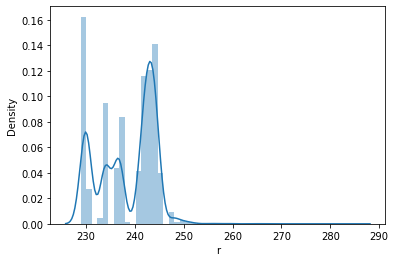

In [21]:
sns.distplot(rfm.r)

Здесь можно выделить 2 категории с разбивкой в 94, назовем их "предусмотрительными" и "прокрастинаторами", а еще 12 человек не сдали экзамен потому что отправили позже окончания семестра, выделим их в отдельную категорию "опоздавших"

In [22]:
rfm.query('r>100').id.count()

5015

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


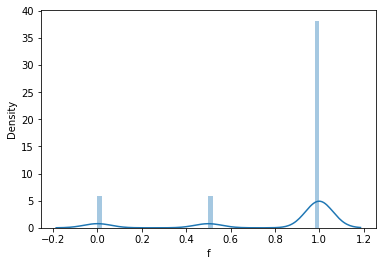

In [23]:
sns.distplot(rfm.f)

Здесь есть 3 катеогии по успешности сдачи экзаменов. "Не успешные", "Справившиеся", "Успешные". Важно отметить, что результат 0.5  вызван разнгыми результатами на разных курсах

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


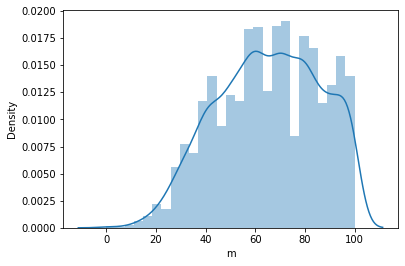

In [24]:
sns.distplot(rfm.m)

Здесь распределение без ярко выраженных границ, однако его тоже разделю на 3 категории.
"Не сдал" - от 0 до 40 баллов
"Сдал" - от 41 до 79 баллов
"Отличник" - от 80 до 100 баллов

In [25]:
def r_score(x):
    if x >= 246:
        return 1 #поздние сдачи
    elif (239 < x)and(x < 246):
        return 2 #основной пик
    else:
        return 3 #первые пики
    
def f_score(x):
    if x == 1:
        return 3
    elif x == 0.5:
        return 2
    else:
        return 1

def m_score(x):
    if x >= 80:
        return 3
    elif x < 80 and x > 40:
        return 2
    else:
        return 1   

In [26]:
rfm['R'] = rfm['r'].apply(lambda x: r_score(x))
rfm['F'] = rfm['f'].apply(lambda x: f_score(x))
rfm['M'] = rfm['m'].apply(lambda x: m_score(x))
rfm

,id,r,f,m,R,F,M
0,558914,230,0.0,32.0,3,1,1
1,558914,230,0.0,36.0,3,1,1
2,559706,234,0.5,78.0,3,2,2
3,559706,230,0.5,73.0,3,2,2
4,559770,230,1.0,54.0,3,3,2
...,...,...,...,...,...,...,...
5010,652680,243,1.0,91.0,2,3,3
5011,652732,249,1.0,47.0,1,3,2
5012,652965,242,1.0,87.0,2,3,3
5013,653051,242,0.0,27.0,2,1,1


In [27]:
segt_map = {
    r'33': 'Лучшие студенты',
    r'23': 'Отлично',
    r'32': 'Справились заранее',
    r'22': 'Успели сдать',
    r'21': 'Не справились',
    r'31': 'Поторопились',
    r'13': 'Отлично в конце семестра',
    r'12': 'Сдали в конце семестра',
    r'11': 'Не сдали в конце семестра'
}

rfm['segment'] = rfm['R'].map(str) + rfm['M'].map(str)
rfm['segment'] = rfm['segment'].replace(segt_map, regex=True)
rfm.head()

,id,r,f,m,R,F,M,segment
0,558914,230,0.0,32.0,3,1,1,Поторопились
1,558914,230,0.0,36.0,3,1,1,Поторопились
2,559706,234,0.5,78.0,3,2,2,Справились заранее
3,559706,230,0.5,73.0,3,2,2,Справились заранее
4,559770,230,1.0,54.0,3,3,2,Справились заранее


In [28]:
rfm.groupby(['R','M'],as_index=False)\
    .agg({'segment':'unique'})\
    .pivot(index='R',columns='M',values='segment')

M,1,2,3
R,,,
1,[Не сдали в конце семестра],[Сдали в конце семестра],[Отлично в конце семестра]
2,[Не справились],[Успели сдать],[Отлично]
3,[Поторопились],[Справились заранее],[Лучшие студенты]


'Лучшие студенты' - оценка больше 80, экзамен сдан заранее

'Отлично' - оценка больше 80, экзамен сдан около дедлайна

'Справились заранее' - оценка ниже 80, но больше 40, экзамен сдан заранее

'Успели сдать' - оценка ниже 80, но больше 40, экзамен сдан около дедлайна

'Не справились' - оценка ниже 40, экзамен сдан около дедлайна

'Поторопились' - оценка ниже 40, экзамен сдан заранее

'Отлично в конце семестра' - оценка больше 80, экзамен сдан в конце окончания семестра

'Сдали в конце семестра' - оценка ниже 80, но больше 40, экзамен сдан в конце окончания семестра

'Не сдали в конце семестра' - оценка ниже 40, экзамен сдан в конце окончания семестра


В данном случае переменная F является зависисмой от двух других, так как упроцент успеха связан с временем сдачи и оценкой. Тогда буду проводить именно RM оценку, ее можно наглядно показать в 2D

In [29]:
rm = rfm.groupby(['R','M'],as_index=False)\
    .agg({'segment':'unique','id':'count'})
rm['value'] = [str(rm.segment[x][0]) + ' ' + str(rm.id[x]) + ' студентов'  for x in rm.index]
rm = rm.pivot(index='R',columns='M',values='value')
rm

M,1,2,3
R,,,
1,Не сдали в конце семестра 7 студентов,Сдали в конце семестра 38 студентов,Отлично в конце семестра 46 студентов
2,Не справились 371 студентов,Успели сдать 1432 студентов,Отлично 774 студентов
3,Поторопились 329 студентов,Справились заранее 1382 студентов,Лучшие студенты 636 студентов


Среди студентов сдававших экзамен раньше всего и в основной поток (R = 2, 3) заметна приблизетельная пропорция 1:4:2 между получившими меньше 40, сдавших экзамен и получивших больше 80 баллов.

Присутствует малое количество студентов сдававших экзамен позже подавляющего большинства. Среди этих студентов отличников больше чем сдавших экзамен на менее чем 80 баллов.